# Quantum Generative Adversarial Networks (QGANs)
***
Generative AI, especially through Generative Adversarial Networks (GANs), revolutionizes content creation across various domains by producing highly realistic outputs. Quantum GANs further elevate this potential by leveraging quantum computing, promising unprecedented advancements in complex data simulation and analysis. 
***
In this notebook, we'll explore the concept of Quantum Generative Adversarial Networks (QGANs) and implement a simple QGAN model using the Classiq SDK.

We study a simple usecase of Bars and Stripes dataset. We begin with a classical implementation of a GAN, and then move to a hybrid quantum-classical GAN model.

## 1 Data Preparation

We generate the Bars and Stripes dataset, a simple binary dataset consisting of 2x2 images with either a horizontal or vertical stripe pattern.

In [2]:
import time

import numpy as np


# Function to create Bars and Stripes dataset
def create_bars_and_stripes_dataset(num_samples):
    samples = []
    for _ in range(num_samples):
        horizontal = np.random.randint(0, 2) == 0
        if horizontal:
            stripe = np.random.randint(0, 2, size=(2, 1))
            sample = np.tile(stripe, (1, 2))
        else:
            stripe = np.random.randint(0, 2, size=(1, 2))
            sample = np.tile(stripe, (2, 1))
        samples.append(sample)
    return np.array(samples, dtype=np.uint8)

In [3]:
# Generate Bars and Stripes dataset
dataset = create_bars_and_stripes_dataset(num_samples=1000)

### 1.1 Visualizing the generated data 
Let's plot a few samples from the dataset to visualize the Bars and Stripes patterns:


In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


# Plot images in a 3 by 3 grid
def plot_nine_images(generated_images):
    # Define custom colormap
    classiq_cmap = LinearSegmentedColormap.from_list(
        "teal_white", [(0, "#00FF00"), (1, "black")]
    )
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i].reshape(2, 2), cmap=classiq_cmap, vmin=0, vmax=1)
        ax.axis("off")
        ax.set_title(f"Image {i+1}")
        for j in range(2):
            for k in range(2):
                label = int(generated_images[i].reshape(2, 2)[j, k])
                ax.text(
                    k,
                    j,
                    f"{label}",
                    ha="center",
                    va="center",
                    color="white" if label == 1 else "black",
                    fontsize=16,
                )
    plt.tight_layout()
    plt.show()

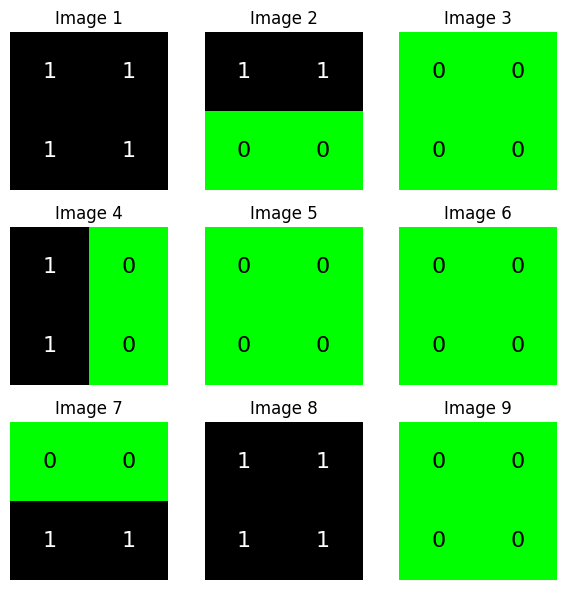

In [5]:
# Generate images
generated_images = create_bars_and_stripes_dataset(9)
plot_nine_images(generated_images)

We create a PyTorch DataLoader to feed the dataset to the GAN model during training.

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader for training
tensor_dataset = TensorDataset(torch.tensor(dataset, dtype=torch.float))
dataloader = DataLoader(tensor_dataset, batch_size=64, shuffle=True)

## 2 Classical network 

### 2.1 Defining a classical GAN

We begin by defining the generator and discriminator models (architecture) for the classical GAN.
We work with `tensorboard` to save our logs (un-comment the following line to install the package).

In [7]:
# ! pip install tensorboard

In [8]:
import pathlib

path = (
    pathlib.Path(__file__).parent.resolve()
    if "__file__" in locals()
    else pathlib.Path(".")
)

In [9]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, input_size=2, output_size=4, hidden_size=32):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size // 2),  # Adjusted hidden layer size
            nn.ReLU(),
            nn.Linear(hidden_size // 2, hidden_size),  # Adjusted hidden layer size
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid(),  # Sigmoid activation to output probabilities
        )

    def forward(self, x):
        return torch.round(self.model(x))


class Discriminator(nn.Module):
    def __init__(self, input_size=4, hidden_size=16):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size // 2),  # Adjusted hidden layer size
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size // 2, hidden_size),  # Adjusted hidden layer size
            nn.LeakyReLU(0.25),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),  # Sigmoid activation to output probabilities
        )

    def forward(self, x):
        x = x.view(-1, 4)  # Flatten input for fully connected layers
        return self.model(x)

### 2.2 Training a classical GAN

**Training loop** $\rightarrow$ Define the training loop for the classical GAN:

In [10]:
import os
from datetime import datetime

import torch
import torch.nn as nn
import torchvision.utils as vutils
from torch.utils.tensorboard import SummaryWriter


def train_gan(
    generator,
    discriminator,
    dataloader,
    log_dir_name,
    fixed_noise,
    random_fake_data_generator,
    num_epochs=100,
    device="cpu",
):

    # Initialize TensorBoard writer
    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    log_dir = os.path.join(log_dir_name, run_id)
    writer = SummaryWriter(log_dir=log_dir)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

    generator.to(device)
    discriminator.to(device)

    for epoch in range(num_epochs):
        for i, batch in enumerate(dataloader):
            real_data = batch[0].to(device)
            batch_size = real_data.size(0)

            # Train Discriminator with real data
            d_optimizer.zero_grad()
            real_output = discriminator(real_data)
            d_real_loss = criterion(real_output, torch.ones_like(real_output))
            d_real_loss.backward()

            # Train Discriminator with fake data
            z = random_fake_data_generator(batch_size)
            fake_data = generator(z)
            fake_output = discriminator(fake_data.detach())
            d_fake_loss = criterion(fake_output, torch.zeros_like(fake_output))
            d_fake_loss.backward()
            d_optimizer.step()

            # Train Generator
            g_optimizer.zero_grad()
            z = random_fake_data_generator(batch_size)
            fake_data = generator(z)
            fake_output = discriminator(fake_data)
            g_loss = criterion(fake_output, torch.ones_like(fake_output))
            g_loss.backward()
            g_optimizer.step()

            # Log losses to TensorBoard
            step = epoch * len(dataloader) + i
            writer.add_scalar("Generator Loss", g_loss.item(), step)
            writer.add_scalar("Discriminator Real Loss", d_real_loss.item(), step)
            writer.add_scalar("Discriminator Fake Loss", d_fake_loss.item(), step)

            if i % 100 == 0:
                print(
                    f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], "
                    f"Generator Loss: {g_loss.item():.4f}, "
                    f"Discriminator Real Loss: {d_real_loss.item():.4f}, "
                    f"Discriminator Fake Loss: {d_fake_loss.item():.4f}"
                )

        # Generate and log sample images for visualization
        # if (epoch+1) % (num_epochs // 10) == 0:
        #     with torch.no_grad():
        #         generated_images = generator(fixed_noise).detach().cpu()
        #     img_grid = vutils.make_grid(generated_images, nrow=3, normalize=True)
        #     writer.add_image('Generated Images', img_grid, epoch+1)

    # Close TensorBoard writer
    writer.close()

We train our model and save the trained generator in `'generator_model.pth'`.

In [11]:
# Fixed noise for visualizing generated samples
fixed_noise = torch.randn(9, 2)


def random_fake_data_for_gan(batch_size, input_size):
    return torch.randn(batch_size, input_size)

In [14]:
generator = Generator(input_size=2, output_size=4, hidden_size=32)
discriminator = Discriminator(input_size=4, hidden_size=16)

# For simplicitly we load a pretrained model
checkpoint = torch.load(path / "resources/generator_trained_model.pth")
generator.load_state_dict(checkpoint)

train_gan(
    generator=generator,
    discriminator=discriminator,
    dataloader=dataloader,
    log_dir_name="logs",
    fixed_noise=fixed_noise,
    random_fake_data_generator=lambda b_size: random_fake_data_for_gan(b_size, 2),
    num_epochs=10,
    device="cpu",
)

# Save trained generator model
torch.save(generator.state_dict(), path / "resources/generator_model.pth")

Epoch [1/10], Step [1/16], Generator Loss: 0.7932, Discriminator Real Loss: 0.7969, Discriminator Fake Loss: 0.6001
Epoch [2/10], Step [1/16], Generator Loss: 0.7925, Discriminator Real Loss: 0.7889, Discriminator Fake Loss: 0.6039
Epoch [3/10], Step [1/16], Generator Loss: 0.7848, Discriminator Real Loss: 0.7831, Discriminator Fake Loss: 0.6076
Epoch [4/10], Step [1/16], Generator Loss: 0.7795, Discriminator Real Loss: 0.7798, Discriminator Fake Loss: 0.6110
Epoch [5/10], Step [1/16], Generator Loss: 0.7836, Discriminator Real Loss: 0.7729, Discriminator Fake Loss: 0.6115
Epoch [6/10], Step [1/16], Generator Loss: 0.7700, Discriminator Real Loss: 0.7707, Discriminator Fake Loss: 0.6159
Epoch [7/10], Step [1/16], Generator Loss: 0.7697, Discriminator Real Loss: 0.7609, Discriminator Fake Loss: 0.6190
Epoch [8/10], Step [1/16], Generator Loss: 0.7696, Discriminator Real Loss: 0.7577, Discriminator Fake Loss: 0.6213
Epoch [9/10], Step [1/16], Generator Loss: 0.7681, Discriminator Real Lo

### 2.3 Performance evaluation 

In [15]:
# Load state dictionary with mismatched sizes
generator = Generator()
checkpoint = torch.load(path / "resources/generator_model.pth")
generator.load_state_dict(checkpoint)
num_samples = 100
z = random_fake_data_for_gan(num_samples, 2)
gen_data = generator(z)


def evaluate_generator(samples):
    count_err = 0
    for img in samples:
        img = img.reshape(2, 2)
        diag1 = int(img[0, 0]) * int(img[1, 1])
        diag2 = int(img[0, 1]) * (int(img[1, 0]))
        if (diag1 == 1 or diag2 == 1) and diag1 * diag2 != 1:
            count_err += 1
    return (samples.shape[0] - count_err) / samples.shape[0]


accuracy = evaluate_generator(samples=gen_data)
print(f"Classically trained generator accuracy: {accuracy:.2%}%")

Classically trained generator accuracy: 71.00%%


Visualizing generator examples

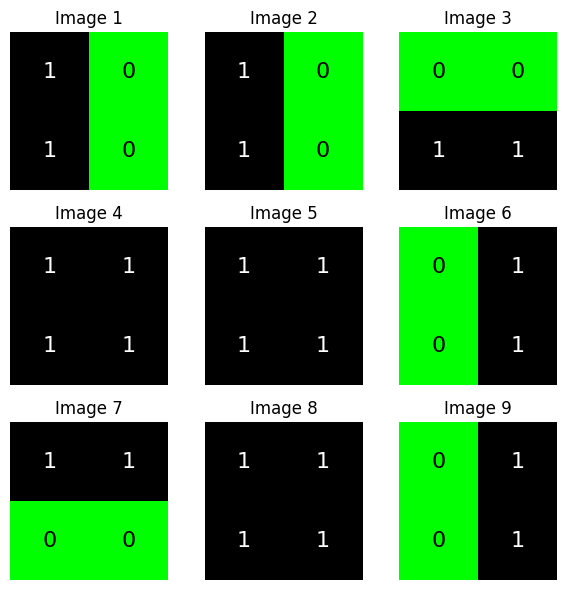

In [16]:
# Initialize generator for evaluation
generator_for_evaluation = Generator(input_size=2, output_size=4)
generator_for_evaluation.load_state_dict(
    torch.load(path / "resources/generator_model.pth")
)  # Load trained model
generator_for_evaluation.eval()

# Generate images
with torch.no_grad():
    noise = torch.randn(9, 2)
    generated_images = generator_for_evaluation(noise).detach().cpu().numpy()

# Plot images in a 3 by 3 grid
generated_images = create_bars_and_stripes_dataset(9)
plot_nine_images(generated_images)


## 3 Quantum hybrid network implementation

In this section we will define a quantum generator circuit and integrate it into a hybrid quantum-classical GAN model. We will then train the QGAN model and evaluate its performance.

### 3.1 Defining the quantum GAN

#### 3.1.1 Defining the quantum generator

We define the three components of the quantum layer - this is where the quantum network architect's creativity comes into play!

The design we choose:
1. Data encoding - we use take a `datum_angle_encoding` that encodes $n$ data points on $n$ qubits.
2. A variational ansatz - we combine RY and RZZ gates.
3. Classical post-process - we take the vector $(p_1, p_2, \dots, p_n)$, with $p_i$ being the probability to measure 1 on the $i$-th qubit.

In [17]:
from typing import List

from classiq import IDENTITY, RX, RY, RZ, RZZ, CArray, CReal, QArray, if_, qfunc, repeat
from classiq.applications.qnn.types import SavedResult
from classiq.qmod.symbolic import floor, pi


@qfunc
def datum_angle_encoding(data_in: CArray[CReal], qbv: QArray) -> None:

    def even_case(exe_params: CArray[CReal], qbv: QArray) -> None:
        repeat(
            count=exe_params.len,
            iteration=lambda index: RX(pi * data_in[index], qbv[index]),
        )
        repeat(
            count=exe_params.len,
            iteration=lambda index: RZ(pi * data_in[index], qbv[index]),
        )

    def odd_case(data_in: CArray[CReal], qbv: QArray) -> None:

        even_case(data_in, qbv)
        RX(pi * data_in[data_in.len - 1], target=qbv[data_in.len])

    if_(
        condition=data_in.len - 2 * (floor(data_in.len / 2)) == 0,
        then=lambda: even_case(data_in, qbv),
        else_=lambda: odd_case(data_in, qbv),
    )


@qfunc
def my_ansatz(weights: CArray[CReal], qbv: QArray) -> None:

    repeat(
        count=qbv.len,
        iteration=lambda index: RY(weights[index], qbv[index]),
    )
    repeat(
        count=qbv.len - 1,
        iteration=lambda index: RZZ(weights[qbv.len + index], qbv[index : index + 2]),
    )
    if_(
        condition=qbv.len > 2,
        then=lambda: RZZ(weights[-1], qbv[0:2]),
        else_=lambda: IDENTITY(qbv[0]),
    )


def my_post_process(result: SavedResult, num_qubits, num_shots) -> torch.Tensor:

    res = result.value
    yvec = [
        (res.counts_of_qubits(k)["1"] if "1" in res.counts_of_qubits(k) else 0)
        / num_shots
        for k in range(num_qubits)
    ]

    return torch.tensor(yvec)

Finally, we define the quantum model with its hyperparameters as our `main`  quantum function, and synthesize it into a quantum program.

In [18]:
import numpy as np

from classiq import (
    CArray,
    CReal,
    Output,
    QArray,
    allocate,
    create_model,
    qfunc,
    show,
    synthesize,
)
from classiq.execution import (
    ExecutionPreferences,
    execute_qnn,
    set_quantum_program_execution_preferences,
)

NUM_SHOTS = 4096
QLAYER_SIZE = 4
num_qubits = int(np.ceil(QLAYER_SIZE))
num_weights = 2 * num_qubits


@qfunc
def main(
    input: CArray[CReal, QLAYER_SIZE],
    weight: CArray[CReal, num_weights],
    result: Output[QArray[num_qubits]],
) -> None:

    allocate(num_qubits, result)
    datum_angle_encoding(data_in=input, qbv=result)

    my_ansatz(weights=weight, qbv=result)


model = create_model(main)
quantum_program = synthesize(model)
show(quantum_program)

quantum_program = set_quantum_program_execution_preferences(
    quantum_program, preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)

Opening: http://localhost:4200/circuit/9a7e39a3-b3e7-4738-b1ac-475970be1ec6?version=0.0.0


**The resulting circuit is**:

<center>
<img src="https://classiq-docs-images.s3.amazonaws.com/qgan_circuit.png" style="width:100%">
<figcaption align = "middle"> Hierarchical view of the quantum circuit for the QGAN generator. The circuit consists of an angle encoding layer, an ansatz layer, and a post-processing layer </figcaption>
</center>

<center>
<img src="https://classiq-docs-images.s3.amazonaws.com/qgan_angle_encoder.png" style="width:100%">
<figcaption align = "middle"> Angle encoding layer consists of two consecutive noncommuting rotations encoding a single datum. </figcaption>
</center>

<center>
<img src="https://classiq-docs-images.s3.amazonaws.com/qgan_anzats.png" style="width:100%">
<figcaption align = "middle"> Ansatz layer including parametrized rotation followed by a pair-wise entangler via RZZ gate sequence. </figcaption>
</center>

#### 3.1.2 Defining the hybrid network

We define the network building blocks: the generator and discriminator in a hybrid network configuration with a quantum layer,

In [19]:
import torch.nn as nn

from classiq.applications.qnn import QLayer


def create_net(*args, **kwargs) -> nn.Module:
    class QGenerator(nn.Module):
        def __init__(self, *args, **kwargs):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear_1 = nn.Linear(4, 16)
            self.linear_2 = nn.Linear(16, 32)
            self.linear_3 = nn.Linear(32, 16)
            self.linear_4 = nn.Linear(16, 4)
            self.linear_5 = nn.Linear(2, 4)
            self.activation_1 = nn.ReLU()
            self.activation_2 = nn.Sigmoid()

            self.qlayer = QLayer(
                quantum_program,
                execute_qnn,
                post_process=lambda res: my_post_process(
                    res, num_qubits=num_qubits, num_shots=NUM_SHOTS
                ),
                *args,
                **kwargs,
            )

        def forward(self, x):
            x = self.flatten(x)
            x = self.linear_1(x)
            x = self.activation_2(x)
            x = self.linear_2(x)
            x = self.activation_1(x)
            x = self.linear_3(x)
            x = self.activation_1(x)
            x = self.linear_4(x)
            x = self.activation_2(x)
            x = self.qlayer(x)
            x = torch.round(self.activation_2(x))
            return x

    return QGenerator(*args, **kwargs)


class Discriminator(nn.Module):
    def __init__(self, input_size=4, hidden_size=16):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size // 2),  # Adjusted hidden layer size
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_size // 2, hidden_size),  # Adjusted hidden layer size
            nn.LeakyReLU(0.25),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),  # Sigmoid activation to output probabilities
        )

    def forward(self, x):
        x = x.view(-1, 4)  # Flatten input for fully connected layers
        return self.model(x)

In [20]:
q_gen = create_net()

### 3.3 Training the QGAN

We can use the training loops defined above for the classical GAN

In [21]:
# Fixed noise for visualizing generated samples
fixed_noise = torch.randn(4)


def random_fake_data_for_qgan(batch_size, input_size):
    return torch.bernoulli(torch.rand(batch_size, input_size))

The following cell generates an archive of the training process in the `q_logs` directory. We will also use Tensorboard to monitor the training in real time. It is possible to use an online version which is more convenient, but for the purpose of this notebook we will use the local version. Example of vizualization output that can be obtained from `tensorboard` is shown in the next figure.

In [22]:
# ## generate tensorboard log directory
# #
# # log_dir = 'MY_LOG_DIR'
# # if not os.path.exists(log_dir):
# #     os.makedirs(log_dir)

# # Launch tensorboard and generate the containing folder internally
# %load_ext tensorboard
# # %reload_ext tensorboard
# %tensorboard --logdir='MY_LOG_DIR/q_logs'

<center>
<img src="https://classiq-docs-images.s3.amazonaws.com/qgan_training.png" style="width:100%">
<figcaption align = "middle"> Example of two training sessions. The first (green) line depicts a process in which the loss function estimator is raising, a clear indication that the learning session does not seem to converge to the desired result. The second (orange) shows the convergence of both. The two components compete to improve their performance. </figcaption>
</center>

***
Since training can take long time to run, we take a pre-trained model, whose parameters are stored in `q_generator_trained_model.pth`. In addition, we take a smaller sample size of 250. (The pre-trained model was trained on 1000 samples). To train a randomly initialized QGAN change `num_samples` from 250 to 1000 for the data creation, and `num_epochs` from 1 to 10 in the training call `train_gan`.
***

In [24]:
# Create training dataset for qgan
qgan_training_dataset = create_bars_and_stripes_dataset(
    num_samples=250
    # num_samples=1000
)

# Convert to PyTorch tensor
qgan_tensor_dataset = torch.tensor(qgan_training_dataset, dtype=torch.float32)

# Create a TensorDataset object
qgan_tensor_dataset = TensorDataset(qgan_tensor_dataset)

# Create a DataLoader object
qgan_dataloader = DataLoader(qgan_tensor_dataset, batch_size=64, shuffle=True)

q_generator = q_gen
discriminator = Discriminator(input_size=4, hidden_size=16)

In [25]:
checkpoint = torch.load(path / "resources/q_generator_trained_model.pth")
q_generator.load_state_dict(checkpoint)

train_gan(
    generator=q_generator,
    discriminator=discriminator,
    dataloader=qgan_dataloader,
    log_dir_name="q_logs",
    fixed_noise=fixed_noise,
    random_fake_data_generator=lambda b_size: random_fake_data_for_qgan(b_size, 4),
    num_epochs=1,
    # num_epochs=10,
    device="cpu",
)

# Save trained generator model
torch.save(q_generator.state_dict(), path / "resources/q_generator_model_bs64.pth")

Epoch [1/1], Step [1/4], Generator Loss: 0.7780, Discriminator Real Loss: 0.7836, Discriminator Fake Loss: 0.6129


### 3.3 Performance evaluation 

Finally, we can evaluate the performance of the QGAN, in similar to the classical counterpart.

In [26]:
generator = q_gen
checkpoint = torch.load(path / "resources/q_generator_model_bs64.pth")
generator.load_state_dict(checkpoint)
num_samples = 10
z = torch.bernoulli(torch.rand(num_samples, 4))
gen_data = generator(z)

accuracy = evaluate_generator(samples=gen_data)
print(f"Quantum-classical hybrid trained generator accuracy: {accuracy:.2%}%")

Quantum-classical hybrid trained generator accuracy: 100.00%%


In [27]:
z = random_fake_data_for_qgan(10, 4)
gen_data = generator(z)
print(gen_data)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], grad_fn=<RoundBackward0>)


***
Why do you think the accuracy is so high?

Answer$\rightarrow$ the system had chosen a metastable pathway where no violation of the rules occur! Try: longer training, different set of hyperparameters, different architecture, etc.